## Set up dataset

In [ ]:
#pip install torch==1.7.1 torchvision==0.8.2

In [ ]:
from robustness.model_utils import make_and_restore_model
from torch.hub import load_state_dict_from_url

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from torchvision.models import resnet50

In [ ]:
ATTACK_EPS = 0.5
ATTACK_STEPSIZE = 0.1
ATTACK_STEPS = 10
NUM_WORKERS = 8
BATCH_SIZE = 10

In [ ]:
import torch as ch
from robustness.datasets import CIFAR
ds = CIFAR('/tmp')

In [ ]:
from robustness.datasets import CINIC

In [ ]:
ds_CINIC = CINIC('/tmp')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import tensorflow as tf
import torch as ch
from robustness.datasets import CIFAR
from robustness.tools.vis_tools import show_image_row
from robustness.attacker import AttackerModel

## Instantiate model

In [ ]:
#cinic model robustification

In [ ]:
from robustness.datasets import CINIC

data_path = "illusionary robust features/CINIC"  # Path to your CINIC-10 dataset
cinic_dataset = CINIC(data_path)

# Load your data loaders
train_loader, test_loader = cinic_dataset.make_loaders(workers=NUM_WORKERS, batch_size=BATCH_SIZE)


==> Preparing dataset cinic..


In [ ]:
from robustness.model_utils import make_and_restore_model

# You can use models like 'resnet18', 'vgg16', or custom ones
model_realcinic_kwargs = {"arch": "resnet50", "dataset": cinic_dataset, "resume_path": None}
model_realcinic, _ = make_and_restore_model(**model_realcinic_kwargs)


In [ ]:
from cox.utils import Parameters
import cox.store
# Create a cox store for logging
OUT_DIR = "illusionary robust features/CINIC/model_cinic"
out_store = cox.store.Store( OUT_DIR )

In [ ]:
# Adversarial training parameters (you can adjust these)
train_kwargs = {
    'out_dir': OUT_DIR,
    'adv_train': 1,            # Use adversarial training
    'constraint': '2',         # '2' for L2 norm, 'inf' for Linf norm
    'eps': 0.5,                # Epsilon for adversarial attack
    'attack_lr': 1.5,          # Learning rate for PGD attack
    'attack_steps': 20         # Number of steps in PGD attack
}
train_args = Parameters(train_kwargs)



In [ ]:
from robustness import model_utils, datasets, train, defaults

# Fill missing arguments with default settings
train_args = defaults.check_and_fill_args(train_args, defaults.TRAINING_ARGS, CINIC)
train_args = defaults.check_and_fill_args(train_args, defaults.PGD_ARGS, CINIC)


In [ ]:
# Train the model using adversarial training
train.train_model(train_args, model_realcinic, (train_loader, test_loader), store=out_store)


Train Epoch:0 | Loss 2.5837 | AdvPrec1 10.816 | AdvPrec5 52.244 | Reg term: 0.0 ||:  31%|███       | 2807/9000 [24:33<53:59,  1.91it/s]  

In [ ]:
# Restore the trained model
model_realcinic, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds_CINIC, resume_path='path/to/checkpoint.pth')


NameError: name 'model_utils' is not defined

In [ ]:
model_realcinic = model_realcinic.to(device)

In [ ]:
#dataset robustification

In [ ]:
from robustness.model_utils import make_and_restore_model
model_CINIC, _ = make_and_restore_model(arch='resnet50', dataset=ds_CINIC,
             resume_path='cifar_l2_0_5.pt')
model_CINIC.eval()
pass


=> loading checkpoint 'cifar_l2_0_5.pt'


RuntimeError: CUDA error: out of memory

In [ ]:
from robustness.datasets import CINIC

data_path = "illusionary robust features/CINIC"  # Path to your CINIC-10 dataset
cinic_dataset = CINIC(data_path)

# Load your data loaders
train_loader, test_loader = cinic_dataset.make_loaders(workers=NUM_WORKERS, batch_size=BATCH_SIZE)
_, (im, label) = next(enumerate(test_loader))

==> Preparing dataset cinic..


THCudaCheck FAIL file=/pytorch/aten/src/THC/THCCachingHostAllocator.cpp line=278 error=2 : out of memory


RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/data/leuven/352/vsc35276/miniconda3/envs/env_rooz/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 31, in _pin_memory_loop
    data = pin_memory(data)
  File "/data/leuven/352/vsc35276/miniconda3/envs/env_rooz/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 55, in pin_memory
    return [pin_memory(sample) for sample in data]
  File "/data/leuven/352/vsc35276/miniconda3/envs/env_rooz/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 55, in <listcomp>
    return [pin_memory(sample) for sample in data]
  File "/data/leuven/352/vsc35276/miniconda3/envs/env_rooz/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 47, in pin_memory
    return data.pin_memory()
RuntimeError: cuda runtime error (2) : out of memory at /pytorch/aten/src/THC/THCCachingHostAllocator.cpp:278


In [ ]:
#first of all accuracy

In [ ]:
# Define the evaluation function to compute accuracy
def evaluate(model, data_loader):
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    # Move the model to the device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate the loss
            total_loss += loss.item()

            # Get the predicted classes
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute accuracy and average loss
    accuracy = correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss


# Evaluate the model on the test set
test_accuracy, test_loss = evaluate(model_CINIC, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 0.7137
Test Loss: 0.1024


In [ ]:
#first untargeted attack

In [ ]:
kwargs = {
    'constraint':'2', # use L2-PGD
    'eps': ATTACK_EPS, # L2 radius around original image
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'do_tqdm': True,
}

In [ ]:
model_CINIC = model_CINIC.to(device)

In [ ]:
im = im.to(device)  # Move the input image to the correct device
label = label.to(device)  # Move the label to the correct device

In [ ]:
_, im_adv = model_CINIC(im, label, make_adv=True, **kwargs)


Current loss: 2.0984275341033936: 100%|██████████| 10/10 [00:00<00:00, 14.68it/s]


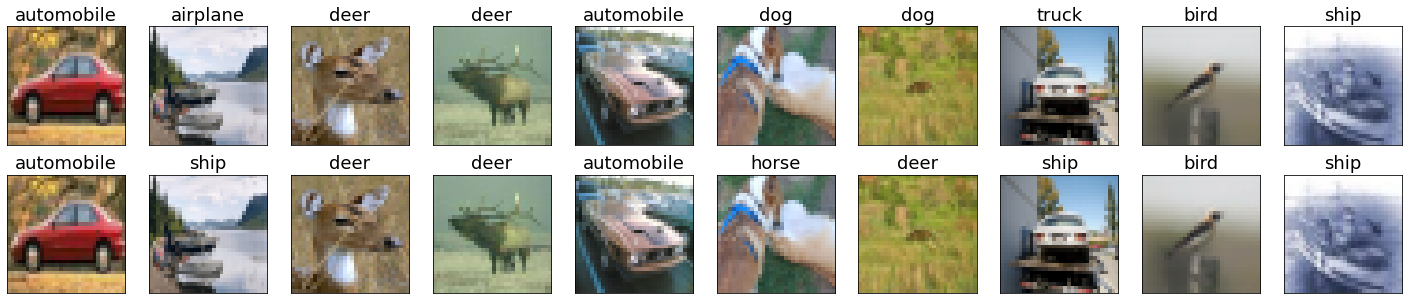

In [ ]:
from robustness.tools.vis_tools import show_image_row
from robustness.tools.label_maps import CLASS_DICT

# Get predicted labels for adversarial examples
pred, _ = model_CINIC(im_adv)
label_pred = ch.argmax(pred, dim=1)

# Visualize test set images, along with corresponding adversarial examples
show_image_row([im.cpu(), im_adv.cpu()],
         tlist=[[CLASS_DICT['CIFAR'][int(t)] for t in l] for l in [label, label_pred]],
         fontsize=18,
         filename='./adversarial_example_CINIC.png')

In [ ]:
#targeted attack

In [ ]:
kwargs = {
    'constraint':'2',
    'eps': ATTACK_EPS,
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'targeted': True,
    'do_tqdm': True
}

In [ ]:
targ = ch.zeros_like(label)


In [ ]:
_, im_adv = model_CINIC(im, targ, make_adv=True, **kwargs)


Current loss: 3.835688352584839: 100%|██████████| 10/10 [00:00<00:00, 14.68it/s]


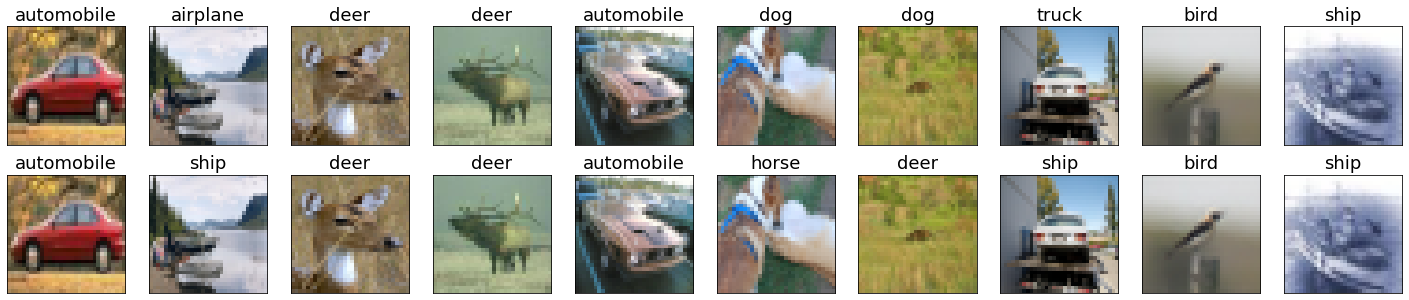

In [ ]:
# Visualize test set images, along with corresponding adversarial examples
show_image_row([im.cpu(), im_adv.cpu()],
         tlist=[[CLASS_DICT['CIFAR'][int(t)] for t in l] for l in [label, label_pred]],
         fontsize=18,
         filename='./adversarial_example_CINIC.png')

In [ ]:
#Custom Input Manipulation (Representation Inversion)


In [ ]:
_, (im_inv, label_inv) = next(enumerate(test_loader)) # Images to invert
with ch.no_grad():
    (_, rep_inv), _ = model_CINIC(im_inv.to(device), with_latent=True) # Corresponding representation

In [ ]:
def inversion_loss(model, inp, targ):
    # Compute representation for the input
    _, rep = model(inp, with_latent=True, fake_relu=True)
    # Normalized L2 error w.r.t. the target representation
    loss = ch.div(ch.norm(rep - targ, dim=1), ch.norm(targ, dim=1))
    return loss, None

In [ ]:
kwargs = {
    'custom_loss': inversion_loss,
    'constraint':'2',
    'eps': 1000,
    'step_size': 1,
    'iterations': 1000,
    'targeted': True,
    'do_tqdm': True,
}

In [ ]:
im_seed = ch.clamp(ch.randn_like(im_inv) / 20 + 0.5, 0, 1)


In [ ]:
_, im_matched = model_CINIC(im_seed.to(device), rep_inv.to(device), make_adv=True, **kwargs)


Current loss: 0.1022067591547966: 100%|██████████| 1000/1000 [00:40<00:00, 24.48it/s]


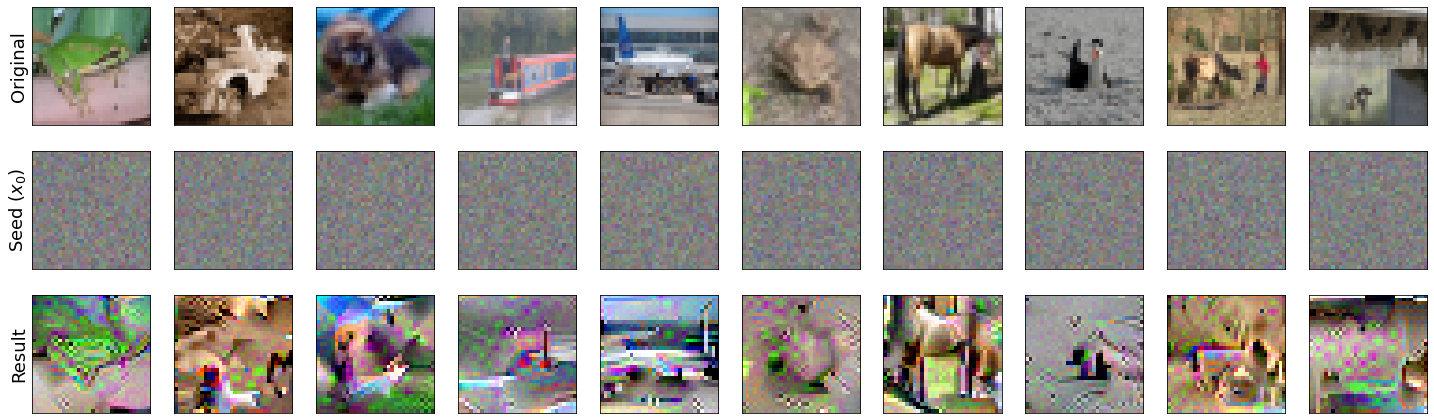

In [ ]:
show_image_row([im_inv.cpu(), im_seed.cpu(), im_matched.cpu()],
         ["Original", r"Seed ($x_0$)", "Result"],
         fontsize=18,
         filename='./custom_inversion_CINIC.png')

In [ ]:
train_loader, test_loader = cinic_dataset.make_loaders(workers=NUM_WORKERS, batch_size=5000)

==> Preparing dataset cinic..


In [ ]:
_, (im_inv, label_inv) = next(enumerate(test_loader)) # Images to invert

In [ ]:
im_seed = ch.clamp(ch.randn_like(im_inv) / 20 + 0.5, 0, 1)


In [ ]:
robustified_images = ch.zeros_like(im_inv)

# Loop over in steps of 10 for batch processing
for t in range(0, 5*1000, 10):
    end_idx = min(t + 10, len(im_inv))  # Ensure no out-of-bounds indexing
    im_batch = im_inv[t:end_idx].to(device)
    seed_batch = im_seed[t:end_idx].to(device)

    with ch.no_grad():
        # Get the corresponding representation
        (_, rep_inv), _ = model_CINIC(im_batch, with_latent=True)

    # Generate adversarially matched images using the representation
    _, im_matched = model_CINIC(seed_batch, rep_inv.to(device), make_adv=True, **kwargs)

    # Store robustified images
    robustified_images[t:end_idx] = im_matched


Current loss: 0.10123451054096222:  82%|████████▎ | 825/1000 [00:33<00:07, 24.24it/s]

In [ ]:
train_loader, test_loader = cinic_dataset.make_loaders(workers=NUM_WORKERS, batch_size=50000)

==> Preparing dataset cinic..


In [ ]:
#pure (or real) robustification

In [ ]:
from robustness.datasets import CINIC

data_path = "illusionary robust features/CINIC"  # Path to your CINIC-10 dataset
cinic_dataset = CINIC(data_path)

# Load your data loaders
train_loader, test_loader = cinic_dataset.make_loaders(workers=NUM_WORKERS, batch_size=BATCH_SIZE)

In [ ]:
from robustness.model_utils import make_and_restore_model
model_CINIC, _ = make_and_restore_model(arch='resnet50', dataset=ds_CINIC,
             resume_path='cifar_l2_0_5.pt')
model_CINIC.eval()
pass

=> loading checkpoint 'cifar_l2_0_5.pt'
=> loaded checkpoint 'cifar_l2_0_5.pt' (epoch 153)


In [ ]:
# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attacker_model = models.resnet50(pretrained=False)
num_ftrs = attacker_model.fc.in_features
attacker_model.fc = nn.Linear(num_ftrs, 10)

loaded_attacker_model = models.resnet50(pretrained=False)
loaded_attacker_model.fc = nn.Linear(num_ftrs, 10)
loaded_attacker_model.load_state_dict(torch.load(r"illusionary robust features/resnet50_cifar10_model_incorrect_lable.pth"))
loaded_attacker_model = loaded_attacker_model.to(device)

In [ ]:
# Access the state_dict of the loaded_attacker_model
state_dict = loaded_attacker_model.state_dict()
state_dict['fc.weight'].shape

torch.Size([10, 2048])

In [ ]:
state_dict['fc.weight']

tensor([[-0.0038, -0.0254,  0.0018,  ...,  0.0565, -0.0469, -0.0114],
        [-0.0080, -0.0145,  0.0059,  ..., -0.0025, -0.0051,  0.0112],
        [ 0.0423, -0.0104,  0.0112,  ...,  0.0341,  0.0565,  0.0244],
        ...,
        [-0.0077,  0.0140, -0.0125,  ...,  0.0003, -0.0396, -0.0239],
        [-0.0049, -0.0312,  0.0041,  ..., -0.0008, -0.0484, -0.0242],
        [-0.0165,  0.0305, -0.0059,  ..., -0.0190, -0.0036, -0.0040]],
       device='cuda:0')

In [ ]:
rep_attacker = state_dict['fc.weight']

In [ ]:
train_loader, test_loader = cinic_dataset.make_loaders(workers=NUM_WORKERS, batch_size=5000)

==> Preparing dataset cinic..


In [ ]:
_, (im_inv, label_inv) = next(enumerate(test_loader)) # Images to invert

In [ ]:
im_seed = ch.clamp(ch.randn_like(im_inv) / 20 + 0.5, 0, 1)


In [ ]:
def custom_loss(model_CINIC, inputs, targ):
    # Compute representations for the input
    _, rep_defender = model_CINIC.to(device)(inputs, with_latent=True, fake_relu=True)
    state_dict1 = loaded_attacker_model.to(device).state_dict()
    rep_attacker = state_dict1['fc.weight']
    # Compute losses for the defender and attacker models
    loss_defender = ch.div(ch.norm(rep_defender - targ, dim=1), ch.norm(targ, dim=1))
    loss_attacker = -ch.div(ch.norm(rep_attacker - targ, dim=1), ch.norm(targ, dim=1))

    # Compute weighted sum of losses
    loss = loss_defender + loss_attacker

    return loss, None

In [ ]:
kwargs = {
    'custom_loss': custom_loss,
    'constraint':'2',
    'eps': 1000,
    'step_size': 1,
    'iterations': 1000,
    'targeted': True,
    'do_tqdm': True,
}

In [ ]:
robustified_images = ch.zeros_like(im_inv)

# Loop over in steps of 10 for batch processing
for t in range(0, 5*1000, 10):
    end_idx = min(t + 10, len(im_inv))  # Ensure no out-of-bounds indexing
    im_batch = im_inv[t:end_idx].to(device)
    seed_batch = im_seed[t:end_idx].to(device)

    with ch.no_grad():
        # Get the corresponding representation
        (_, rep_inv), _ = model_CINIC(im_batch, with_latent=True)

    # Generate adversarially matched images using the representation
    _, im_matched = model_CINIC(seed_batch, rep_inv.to(device), make_adv=True, **kwargs)

    # Store robustified images
    robustified_images[t:end_idx] = im_matched


Current loss: -0.8790376782417297:  16%|█▌        | 156/1000 [00:06<00:33, 24.85it/s]